In [1]:
import gym
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import time

### Parameters chosen

In [10]:
EPSILON = 0.6
TEST_EPISODE_COUNT = 1
EPISODE_COUNT = 10000
env = gym.make('MountainCar-v0')
env_test = gym.make('MountainCar-v0')
env._max_episode_steps = 700    # default steps increased to ease the learning and show better learning comparisons
env_test._max_episode_steps = 700
ALPHA = 0.1
GAMMA = 0.95

### functions to assist converting continuous observation space to discrete

In [11]:
def get_raw_observations(state):
    pos_raw =np.mean(state[0])
    vel_raw =np.mean(state[1])
    
    return np.array([pos_raw, vel_raw])

def get_intervals(lower, upper, num_intervals):
    intervals = np.round(np.linspace(lower, upper, num_intervals), 7)
    intervals_list = []
    for l, u in zip(intervals, intervals[1:]):
        intervals_list.append((l, u))
    return intervals_list

def get_states(pos_intervals, vel_intervals):
    states = []
    for pos in pos_intervals:
        for vel in vel_intervals:
            
            states.append((pos, vel))
            
    return states

def get_discretized_state(obs):

    pos = np.array(pos_intervals)[(np.array(pos_intervals)[:, 0] <= obs[0]) & (np.array(pos_intervals)[:, 1] >= obs[0])]
    vel = np.array(vel_intervals)[(np.array(vel_intervals)[:, 0] <= obs[1]) & (np.array(vel_intervals)[:, 1] >= obs[1])]
    
    #print(pos)
    state = (tuple(pos[0]), tuple(vel[0]))
    #print(state)
    return state

In [12]:
# these are all the ranges outside which the episode ends as pole falls down
pos_intervals = get_intervals(-1.2, 0.6, 50)
vel_intervals = get_intervals(-0.07, 0.07, 50)

In [13]:
# we pass the intervals to the get_states and get the all the possible state combinations
states = get_states(pos_intervals, vel_intervals)

In [14]:
states[:10]

[((-1.2, -1.1632653), (-0.07, -0.0671429)),
 ((-1.2, -1.1632653), (-0.0671429, -0.0642857)),
 ((-1.2, -1.1632653), (-0.0642857, -0.0614286)),
 ((-1.2, -1.1632653), (-0.0614286, -0.0585714)),
 ((-1.2, -1.1632653), (-0.0585714, -0.0557143)),
 ((-1.2, -1.1632653), (-0.0557143, -0.0528571)),
 ((-1.2, -1.1632653), (-0.0528571, -0.05)),
 ((-1.2, -1.1632653), (-0.05, -0.0471429)),
 ((-1.2, -1.1632653), (-0.0471429, -0.0442857)),
 ((-1.2, -1.1632653), (-0.0442857, -0.0414286))]

### Helper funcitons

In [49]:
def best_action(state):
    action_value_list = []
    for a in [0, 1, 2]:
        action_value_list.append(Q[(state, a)])
        
    return np.argmax(action_value_list)
    
def epsilon_greedy_policy(state, epsilon):
    if epsilon < np.random.rand():
        action = np.random.choice([0, 1, 2], size=1)[0]
        
    else:
        action = best_action(state)
    
    return action

def test(env, episode_count):
    total_reward = 0
    for i in range(episode_count):
        initial_state = get_discretized_state(env.reset())
        while True:
            action = best_action(initial_state)
            obs, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            next_state = get_discretized_state(obs)
            if done:
                break
                
            initial_state = next_state
            
    return total_reward / episode_count

def plot_progress_curve(rewards_lists, moving_average, labels=None):
    plt.figure(figsize=(10, 8))
    for j, l in enumerate(rewards_lists):
        ma_list = [np.sum(l[i:i+moving_average])/moving_average for i in range(len(l)-moving_average)]
        if labels:
            plt.plot(ma_list, label=labels[j])
        else:
            plt.plot(ma_list)
    plt.xlabel('Episode', fontsize=15)
    plt.ylabel('Total Reward', fontsize=15)
    plt.grid(alpha=0.3)
    plt.legend()

# ---------------------------------------------Task 1-------------------------------------------

# Sarsa

In [16]:
def on_policy_sarsa(test_episode_count, episode_count, env, env_test, epsilon, alpha):
    mean_reward_list = []
    
    for ep in range(episode_count):
        
        initial_state = get_discretized_state(env.reset())
        action = epsilon_greedy_policy(initial_state, epsilon)
        while True:
            obs, reward, done, _ = env.step(action)

            if done:
                # Q value for ending state is taken as 0

                Q[(initial_state, action)] = Q[(initial_state, action)] + alpha*(reward + GAMMA * 0 - Q[(initial_state, action)])

                break

            next_state = get_discretized_state(obs)
            next_action = epsilon_greedy_policy(next_state, epsilon)

            Q[(initial_state, action)] = Q[(initial_state, action)] + alpha * (reward + GAMMA * Q[(next_state, next_action)] - Q[(initial_state, action)])

            initial_state = next_state
            action = next_action
        if ep % 5 == 0:
            mean_reward = test(env_test, test_episode_count)  
        if ep % 500 == 0:
            print(f'Mean reward after {ep+1} episodes is : {mean_reward}')
        mean_reward_list.append(mean_reward)
        
            
         
       
    return mean_reward_list

In [17]:
Q = defaultdict(int)


start_time = time.time()
mean_rewards_on_policy_sarsa = on_policy_sarsa(TEST_EPISODE_COUNT, EPISODE_COUNT, env, env_test, EPSILON, ALPHA)
print('Execution time : ', time.time() - start_time)

Mean reward after 1 episodes is : -700.0
Mean reward after 501 episodes is : -256.0
Mean reward after 1001 episodes is : -203.0
Mean reward after 1501 episodes is : -298.0
Mean reward after 2001 episodes is : -205.0
Mean reward after 2501 episodes is : -158.0
Mean reward after 3001 episodes is : -163.0
Mean reward after 3501 episodes is : -121.0
Mean reward after 4001 episodes is : -257.0
Mean reward after 4501 episodes is : -154.0
Mean reward after 5001 episodes is : -200.0
Mean reward after 5501 episodes is : -123.0
Mean reward after 6001 episodes is : -159.0
Mean reward after 6501 episodes is : -131.0
Mean reward after 7001 episodes is : -155.0
Mean reward after 7501 episodes is : -155.0
Mean reward after 8001 episodes is : -119.0
Mean reward after 8501 episodes is : -116.0
Mean reward after 9001 episodes is : -115.0
Mean reward after 9501 episodes is : -112.0
Execution time :  942.4139981269836


No handles with labels found to put in legend.


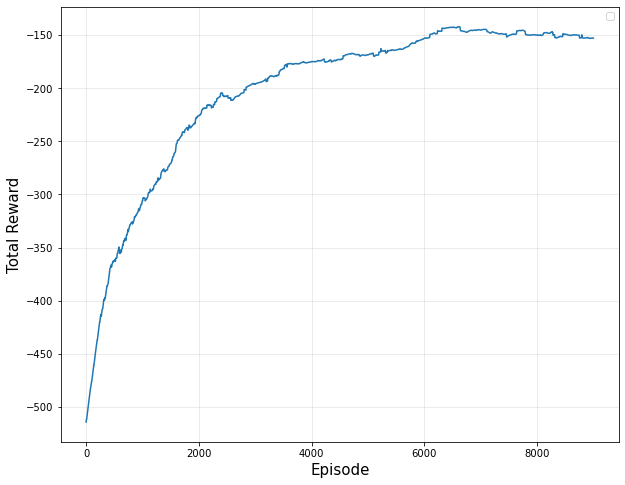

In [50]:
plot_progress_curve([mean_rewards_on_policy_sarsa], 1000)

In [19]:
sorted(mean_rewards_on_policy_sarsa, reverse=True)[:10] # lowest rewards recieved

[-87.0, -87.0, -87.0, -87.0, -87.0, -89.0, -89.0, -89.0, -89.0, -89.0]

## On policy Expected Sarsa

In [20]:
def expected_action_value(state, policy, epsilon):
    if policy == 'off_policy_greedy':
        action = best_action(state)
        probabilities = np.array([0, 0, 0])
        probabilities[action] = 1
        
        
    elif policy == 'on_policy':
        action = epsilon_greedy_policy(state, epsilon)
        probabilities = np.array([epsilon/3 if i != action else (1-epsilon + epsilon/3) for i in [0, 1, 2]])
        
    state_action_values = np.array([Q[(state, action)] for action in [0, 1, 2]])
    expected_value = np.sum(probabilities * state_action_values)
    
    return expected_value

def expected_sarsa(test_episode_count, episode_count, env, env_test, epsilon, alpha, policy):
    mean_reward_list = []
    
    for ep in range(episode_count):
        
        initial_state = get_discretized_state(env.reset())
        action = epsilon_greedy_policy(initial_state, epsilon)
        while True:
            obs, reward, done, _ = env.step(action)

            if done:
                # Q value for ending state is taken as 0

                Q[(initial_state, action)] = Q[(initial_state, action)] + alpha*(reward + GAMMA * 0 - Q[(initial_state, action)])

                break

            next_state = get_discretized_state(obs)
            expected_action_values = expected_action_value(next_state, policy, epsilon)

            Q[(initial_state, action)] = Q[(initial_state, action)] + alpha * (reward + GAMMA * expected_action_values - Q[(initial_state, action)])

            initial_state = next_state
            action = epsilon_greedy_policy(next_state, epsilon)
        if ep % 5 == 0:    
            mean_reward = test(env_test, test_episode_count)  
        if ep % 500 == 0:
            print(f'Mean reward after {ep + 1} episodes is : {mean_reward}')
        mean_reward_list.append(mean_reward)
        
            
        
       
    return mean_reward_list

In [21]:
Q = defaultdict(int)


start_time = time.time()
mean_rewards_on_policy_expected_sarsa = expected_sarsa(TEST_EPISODE_COUNT, EPISODE_COUNT, env, 
                                                       env_test, EPSILON, ALPHA, 'on_policy')
print('Execution time : ', time.time() - start_time)

Mean reward after 1 episodes is : -700.0
Mean reward after 501 episodes is : -437.0
Mean reward after 1001 episodes is : -379.0
Mean reward after 1501 episodes is : -286.0
Mean reward after 2001 episodes is : -244.0
Mean reward after 2501 episodes is : -299.0
Mean reward after 3001 episodes is : -202.0
Mean reward after 3501 episodes is : -162.0
Mean reward after 4001 episodes is : -203.0
Mean reward after 4501 episodes is : -160.0
Mean reward after 5001 episodes is : -159.0
Mean reward after 5501 episodes is : -196.0
Mean reward after 6001 episodes is : -154.0
Mean reward after 6501 episodes is : -208.0
Mean reward after 7001 episodes is : -159.0
Mean reward after 7501 episodes is : -159.0
Mean reward after 8001 episodes is : -122.0
Mean reward after 8501 episodes is : -123.0
Mean reward after 9001 episodes is : -137.0
Mean reward after 9501 episodes is : -152.0
Execution time :  1048.442233800888


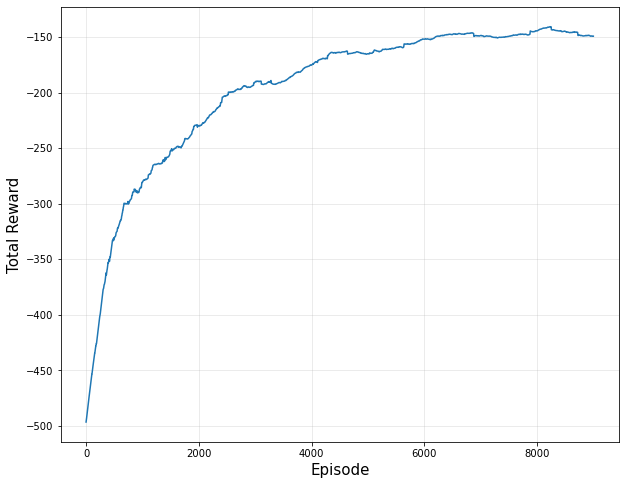

In [22]:
plot_progress_curve(mean_rewards_on_policy_expected_sarsa, 1000)

# Off policy greedy expected sarsa

In [23]:
sorted(mean_rewards_on_policy_expected_sarsa, reverse=True)[:10]

[-92.0, -92.0, -92.0, -92.0, -92.0, -93.0, -93.0, -93.0, -93.0, -93.0]

In [24]:
Q = defaultdict(int)

expectedstart_time = time.time()
mean_rewards_off_greedy_policy_expected_sarsa = expected_sarsa(TEST_EPISODE_COUNT, EPISODE_COUNT, env, 
                                                       env_test, EPSILON, ALPHA, 'off_policy_greedy')
print('Execution time : ', time.time() - start_time)

Mean reward after 1 episodes is : -700.0
Mean reward after 501 episodes is : -700.0
Mean reward after 1001 episodes is : -286.0
Mean reward after 1501 episodes is : -165.0
Mean reward after 2001 episodes is : -266.0
Mean reward after 2501 episodes is : -244.0
Mean reward after 3001 episodes is : -197.0
Mean reward after 3501 episodes is : -178.0
Mean reward after 4001 episodes is : -157.0
Mean reward after 4501 episodes is : -195.0
Mean reward after 5001 episodes is : -202.0
Mean reward after 5501 episodes is : -143.0
Mean reward after 6001 episodes is : -153.0
Mean reward after 6501 episodes is : -133.0
Mean reward after 7001 episodes is : -101.0
Mean reward after 7501 episodes is : -124.0
Mean reward after 8001 episodes is : -152.0
Mean reward after 8501 episodes is : -123.0
Mean reward after 9001 episodes is : -150.0
Mean reward after 9501 episodes is : -151.0
Execution time :  2011.656370639801


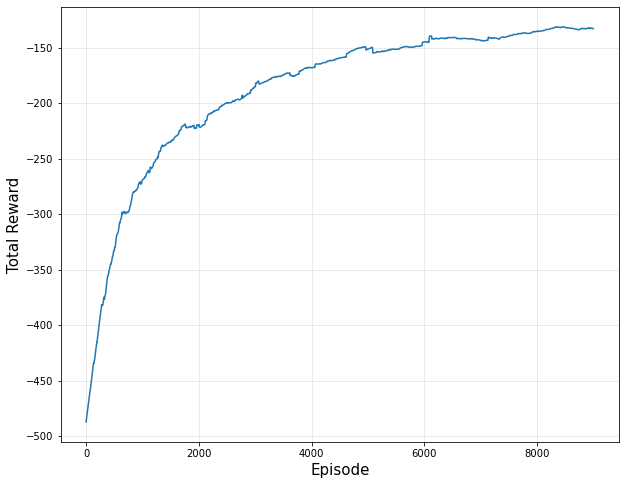

In [25]:
plot_progress_curve(mean_rewards_off_greedy_policy_expected_sarsa, 1000)

In [26]:
sorted(mean_rewards_off_greedy_policy_expected_sarsa, reverse=True)[:10]

[-86.0, -86.0, -86.0, -86.0, -86.0, -87.0, -87.0, -87.0, -87.0, -87.0]

### Comparison

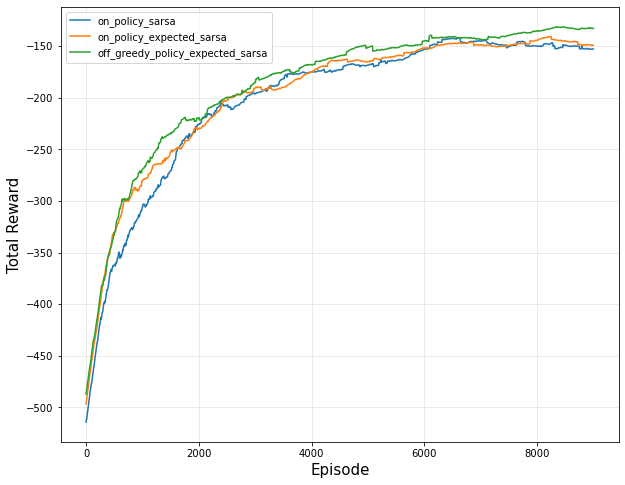

In [51]:
reward_lists = [mean_rewards_on_policy_sarsa, mean_rewards_on_policy_expected_sarsa, mean_rewards_off_greedy_policy_expected_sarsa]
plot_progress_curve(reward_lists, 1000, ['on_policy_sarsa', 'on_policy_expected_sarsa', 'off_greedy_policy_expected_sarsa'])

**From the above graph it can be clearly seen that following points can be discerned:**

* **Speed of convergence** : off_policy_greedy_sarsa > on_policy_expected_sarsa >= on_policy_sarsa, it can be clearly seen that off_policy_greedy_expected sarsa converges the fastest.


* **max reward achieved** : The curve for the off policy greedy expected sarsa subsumes both of the other variants and hence performing the best, which is also the case theoretically.

# ---------------------------------------------Task 2------------------------------------------

# N step Sarsa

In [27]:
def n_step_on_policy_sarsa(test_episode_count, episode_count, env, env_test, epsilon, alpha, n):
    mean_reward_list = []
    for ep in range(episode_count):
        action_list = []
        reward_list = []
        state_list = []
        gamma_list = np.array([GAMMA**i for i in range(n)])
        T = np.inf
        t = 0
        done = False
        initial_state = get_discretized_state(env.reset())
        action = epsilon_greedy_policy(initial_state, epsilon)
        
        state_list.append(initial_state)
        action_list.append(action)
        
        while not done:
            if t < T:
                obs, reward, done, _ = env.step(action)
                reward_list.append(reward)

                next_state = get_discretized_state(obs)
                state_list.append(next_state)
                if done:
                    T = t + 1
                    
                else:
                    next_action = epsilon_greedy_policy(next_state, epsilon)
                    action_list.append(next_action)
                    action = next_action
                
            
            
            tau = t - n + 1
            if tau >= 0:
                
                rewards = np.array(reward_list[tau:min(tau+n, T)])
                G = rewards * gamma_list[:rewards.shape[0]]
                G = np.sum(G)
               
                if tau + n < T:
                    s = state_list[tau+n]
                    a = action_list[tau+n]
                    G += (GAMMA**n)*Q[(s, a)]
                    
                s = state_list[tau]
                a = action_list[tau]
                Q[(s, a)] = Q[(s, a)] + alpha*(G - Q[(s, a)])
                
        
            t += 1
        
    
            
        for tau in range(t-n+1, T):
            rewards = np.array(reward_list[tau:min(tau+n, T)])
            G = rewards * gamma_list[:rewards.shape[0]]
            G = np.sum(G)

            if tau + n < T:
                s = state_list[tau+n]
                a = action_list[tau+n]
                G += (GAMMA**n)*Q[(s, a)]

            s = state_list[tau]
            a = action_list[tau]
            Q[(s, a)] = Q[(s, a)] + alpha*(G - Q[(s, a)])
            
         
        if ep % 5 == 0:    
            mean_reward = test(env_test, test_episode_count)  
        if ep % 500 == 0:
            print(f'Mean reward after {ep + 1} episodes is : {mean_reward}')
        mean_reward_list.append(mean_reward)
        
        
        
       
    return mean_reward_list
        

### 2 step

In [28]:
Q = defaultdict(int)


start_time = time.time()
mean_rewards_on_policy_2_step_sarsa = n_step_on_policy_sarsa(TEST_EPISODE_COUNT, EPISODE_COUNT, env, 
                                                       env_test, EPSILON, ALPHA, 2)
print('Execution time : ', time.time() - start_time)

Mean reward after 1 episodes is : -700.0
Mean reward after 501 episodes is : -399.0
Mean reward after 1001 episodes is : -423.0
Mean reward after 1501 episodes is : -247.0
Mean reward after 2001 episodes is : -186.0
Mean reward after 2501 episodes is : -163.0
Mean reward after 3001 episodes is : -175.0
Mean reward after 3501 episodes is : -131.0
Mean reward after 4001 episodes is : -158.0
Mean reward after 4501 episodes is : -128.0
Mean reward after 5001 episodes is : -124.0
Mean reward after 5501 episodes is : -163.0
Mean reward after 6001 episodes is : -119.0
Mean reward after 6501 episodes is : -117.0
Mean reward after 7001 episodes is : -154.0
Mean reward after 7501 episodes is : -165.0
Mean reward after 8001 episodes is : -110.0
Mean reward after 8501 episodes is : -147.0
Mean reward after 9001 episodes is : -155.0
Mean reward after 9501 episodes is : -149.0
Execution time :  887.3667876720428


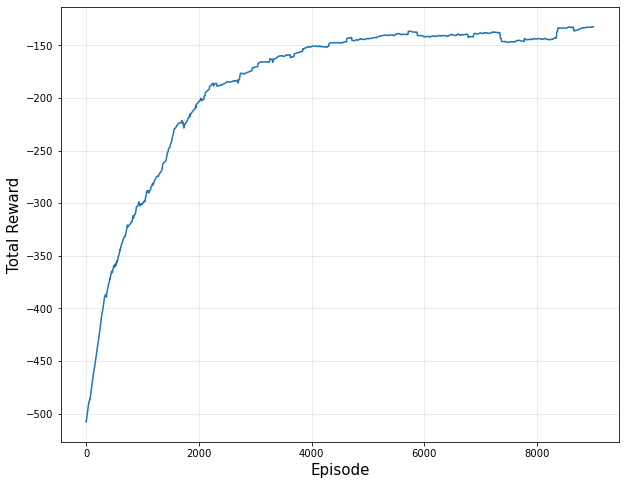

In [29]:
plot_progress_curve(mean_rewards_on_policy_2_step_sarsa, 1000)

### 3 step

In [30]:
Q = defaultdict(int)

start_time = time.time()
mean_rewards_on_policy_3_step_sarsa = n_step_on_policy_sarsa(TEST_EPISODE_COUNT, EPISODE_COUNT, env, 
                                                       env_test, EPSILON, ALPHA, 3)
print('Execution time : ', time.time() - start_time)

Mean reward after 1 episodes is : -700.0
Mean reward after 501 episodes is : -700.0
Mean reward after 1001 episodes is : -326.0
Mean reward after 1501 episodes is : -218.0
Mean reward after 2001 episodes is : -161.0
Mean reward after 2501 episodes is : -153.0
Mean reward after 3001 episodes is : -700.0
Mean reward after 3501 episodes is : -156.0
Mean reward after 4001 episodes is : -157.0
Mean reward after 4501 episodes is : -119.0
Mean reward after 5001 episodes is : -118.0
Mean reward after 5501 episodes is : -172.0
Mean reward after 6001 episodes is : -93.0
Mean reward after 6501 episodes is : -105.0
Mean reward after 7001 episodes is : -114.0
Mean reward after 7501 episodes is : -113.0
Mean reward after 8001 episodes is : -89.0
Mean reward after 8501 episodes is : -142.0
Mean reward after 9001 episodes is : -114.0
Mean reward after 9501 episodes is : -136.0
Execution time :  843.8841705322266


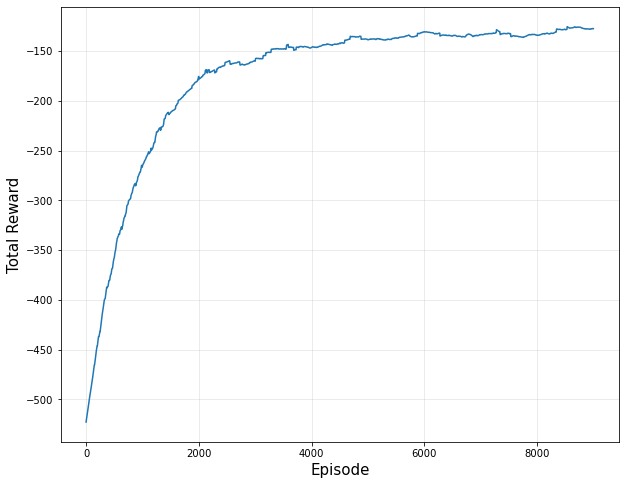

In [31]:
plot_progress_curve(mean_rewards_on_policy_3_step_sarsa, 1000)

### 4 step

In [32]:
Q = defaultdict(int)

start_time = time.time()
mean_rewards_on_policy_4_step_sarsa = n_step_on_policy_sarsa(TEST_EPISODE_COUNT, EPISODE_COUNT, env, 
                                                       env_test, EPSILON, ALPHA, 4)
print('Execution time : ', time.time() - start_time)

Mean reward after 1 episodes is : -700.0
Mean reward after 501 episodes is : -459.0
Mean reward after 1001 episodes is : -261.0
Mean reward after 1501 episodes is : -165.0
Mean reward after 2001 episodes is : -163.0
Mean reward after 2501 episodes is : -132.0
Mean reward after 3001 episodes is : -121.0
Mean reward after 3501 episodes is : -164.0
Mean reward after 4001 episodes is : -161.0
Mean reward after 4501 episodes is : -155.0
Mean reward after 5001 episodes is : -117.0
Mean reward after 5501 episodes is : -150.0
Mean reward after 6001 episodes is : -115.0
Mean reward after 6501 episodes is : -162.0
Mean reward after 7001 episodes is : -116.0
Mean reward after 7501 episodes is : -114.0
Mean reward after 8001 episodes is : -141.0
Mean reward after 8501 episodes is : -121.0
Mean reward after 9001 episodes is : -115.0
Mean reward after 9501 episodes is : -145.0
Execution time :  812.8547646999359


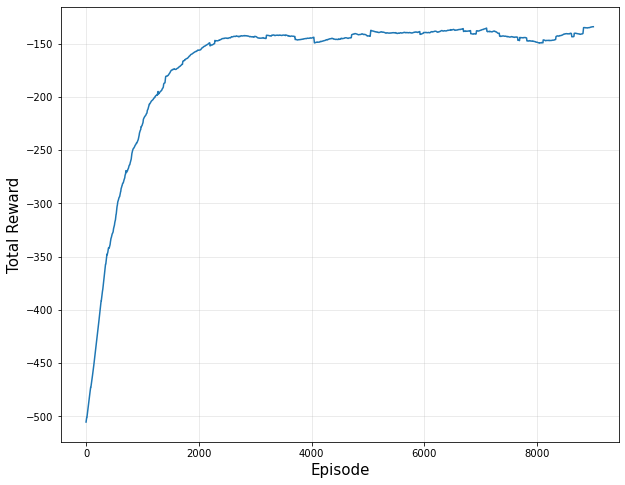

In [33]:
plot_progress_curve(mean_rewards_on_policy_4_step_sarsa, 1000)

### Comparisons

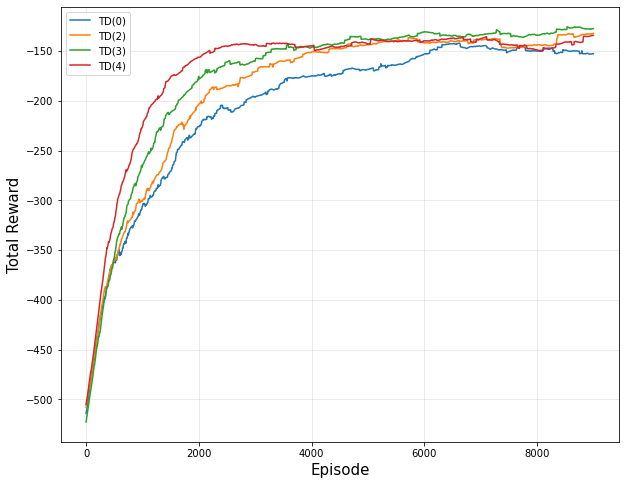

In [52]:
reward_lists = [mean_rewards_on_policy_sarsa, mean_rewards_on_policy_2_step_sarsa, mean_rewards_on_policy_3_step_sarsa, mean_rewards_on_policy_4_step_sarsa]
plot_progress_curve(reward_lists, 1000, ['TD(0)', 'TD(2)', 'TD(3)', 'TD(4)'])

**From the above graph it can be clearly seen that following points can be discerned:**

* **Speed of convergence** : TD(4) > TD(3) > TD(2) > TD(0), We can clearly see that TD(4) converges to the greatest average reward more quickly than the other 3 variants, we can also see that TD(4) reaches the -150 reward mark around 2000 episodes whereas TD(3), TD(2) and TD(0) takes 3500, 4000 and 6000 episodes respectively.


* **max reward achieved** : From the above plot it is quite clear that the best reward is not achieved by TD(0), the other variants perform better with TD(3) achieving the most average rewards followed by TD(4) and TD(2).

# --------------------------------------------Task 3-------------------------------------------

# N step Tree backup

In [111]:
def expected_action_value(state, epsilon, action_taken, root=False):
    
    '''root parameter allows for all three weighted action values to be added as at the root of the tree backup we have to 
       include the action value of the action taken unlike in the case in the above tree backups where we omit the action value
       of action taken at that time step.'''
      
    
    action = epsilon_greedy_policy(state, epsilon)
    probabilities = np.array([epsilon/3 if i != action else (1-epsilon + epsilon/3) for i in [0, 1, 2]])
        
    state_action_values = np.array([Q[(state, action)] for action in [0, 1, 2]])
    
    if not root:
        state_action_values[action_taken] = 0 # make the action value 0 for action taken as it is already been added to G through
                                              # previous tree backup
    expected_value = np.sum(probabilities * state_action_values)
    
    return expected_value


def n_step_tree_backup(test_episode_count, episode_count, env, env_test, epsilon, alpha, n):
    mean_reward_list = []
    epsilon_greedy_probability = 1- epsilon + epsilon/3
    for ep in range(episode_count):
        action_list = []
        reward_list = []
        state_list = []
        gamma_list = np.array([GAMMA**i for i in range(n)])
        T = np.inf
        t = 0
        done = False
        initial_state = get_discretized_state(env.reset())
        action = epsilon_greedy_policy(initial_state, epsilon)
        
        state_list.append(initial_state)
        action_list.append(action)
        
        while not done:
            if t < T:
                obs, reward, done, _ = env.step(action)
                reward_list.append(reward)

                next_state = get_discretized_state(obs)
                
                if done:
                    T = t + 1
                    
                else:
                    next_action = epsilon_greedy_policy(next_state, epsilon)
                    action_list.append(next_action)
                    state_list.append(next_state)
                    action = next_action
                
            
            
            tau = t - n + 1
            
            if tau >= 0:
              
                if t + 1 >= T:
                    
                    G = reward_list[T-1]
                    
                else:
                    
                    eav = expected_action_value(state_list[tau+n], epsilon, action_list[tau+n], True) 
                  
                    G = reward_list[tau+n-1] + GAMMA * eav
                
                
                for i in range(min(tau+n-1, T), tau, -1):
                    eav = expected_action_value(state_list[i], epsilon, action_list[i], True)
               
                    G = reward_list[i-1] + GAMMA * eav + epsilon_greedy_probability*G
                    
                s = state_list[tau]
                a = action_list[tau]
                Q[(s, a)] += alpha * (G - Q[(s, a)])
                
                
            t += 1
                
                
        for tau in range(t-n+1, T):
                
            if t + 1 >= T:
                G = reward_list[T-1]

            else:
                eav = expected_action_value(state_list[tau+n], epsilon, action_list[tau+n], root=True) 
                G = reward_list[tau+n-1] + GAMMA * eav


            for i in range(min(tau+n-1, T-1), tau, -1):
                eav = expected_action_value(state_list[i], epsilon, action_list[i], root=True)
                G = reward_list[i-1] + GAMMA * eav + GAMMA*epsilon_greedy_probability*G

            s = state_list[tau]
            a = action_list[tau]
            Q[(s, a)] += alpha * (G - Q[(s, a)])        
                
      
         
        if ep % 5 == 0:    
            mean_reward = test(env_test, test_episode_count)  
        if ep % 500 == 0:
            print(f'Mean reward after {ep + 1} episodes is : {mean_reward}')
        mean_reward_list.append(mean_reward)
        
        
        
       
    return mean_reward_list

### 2 step

In [107]:
Q = defaultdict(int)

start_time = time.time()
mean_rewards_2_step_tree_backup = n_step_tree_backup(TEST_EPISODE_COUNT, EPISODE_COUNT, env, 
                                                       env_test, EPSILON, ALPHA, 2)
print('Execution time : ', time.time() - start_time)

Mean reward after 1 episodes is : -700.0
Mean reward after 501 episodes is : -700.0
Mean reward after 1001 episodes is : -422.0
Mean reward after 1501 episodes is : -174.0
Mean reward after 2001 episodes is : -247.0
Mean reward after 2501 episodes is : -155.0
Mean reward after 3001 episodes is : -181.0
Mean reward after 3501 episodes is : -197.0
Mean reward after 4001 episodes is : -163.0
Mean reward after 4501 episodes is : -160.0
Mean reward after 5001 episodes is : -152.0
Mean reward after 5501 episodes is : -168.0
Mean reward after 6001 episodes is : -156.0
Mean reward after 6501 episodes is : -182.0
Mean reward after 7001 episodes is : -163.0
Mean reward after 7501 episodes is : -123.0
Mean reward after 8001 episodes is : -160.0
Mean reward after 8501 episodes is : -160.0
Mean reward after 9001 episodes is : -148.0
Mean reward after 9501 episodes is : -197.0
Execution time :  1169.0560953617096


No handles with labels found to put in legend.


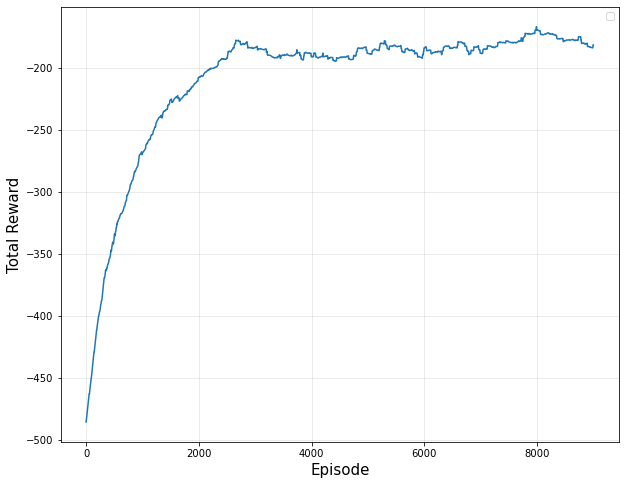

In [109]:
plot_progress_curve([mean_rewards_2_step_tree_backup], 1000)

### 3 step

In [112]:
Q = defaultdict(int)

start_time = time.time()
mean_rewards_3_step_tree_backup = n_step_tree_backup(TEST_EPISODE_COUNT, EPISODE_COUNT, env, 
                                                       env_test, EPSILON, ALPHA, 3)
print('Execution time : ', time.time() - start_time)

Mean reward after 1 episodes is : -700.0
Mean reward after 501 episodes is : -700.0
Mean reward after 1001 episodes is : -335.0
Mean reward after 1501 episodes is : -307.0
Mean reward after 2001 episodes is : -227.0
Mean reward after 2501 episodes is : -700.0
Mean reward after 3001 episodes is : -244.0
Mean reward after 3501 episodes is : -164.0
Mean reward after 4001 episodes is : -163.0
Mean reward after 4501 episodes is : -171.0
Mean reward after 5001 episodes is : -247.0
Mean reward after 5501 episodes is : -227.0
Mean reward after 6001 episodes is : -179.0
Mean reward after 6501 episodes is : -123.0
Mean reward after 7001 episodes is : -179.0
Mean reward after 7501 episodes is : -169.0
Mean reward after 8001 episodes is : -158.0
Mean reward after 8501 episodes is : -146.0
Mean reward after 9001 episodes is : -177.0
Mean reward after 9501 episodes is : -158.0
Execution time :  1313.3543109893799


No handles with labels found to put in legend.


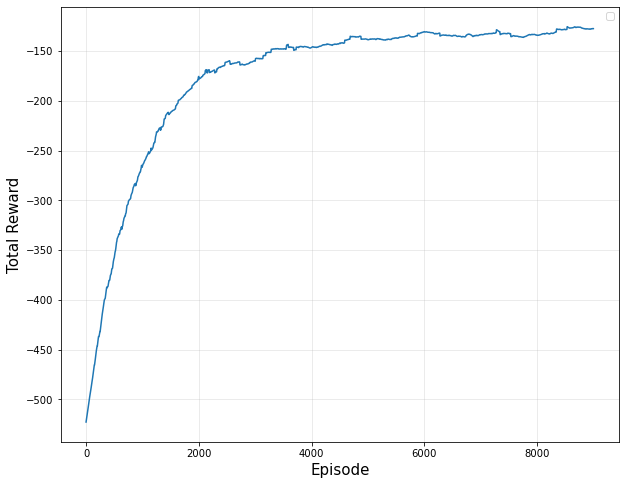

In [114]:
plot_progress_curve([mean_rewards_on_policy_3_step_sarsa], 1000)

### 4 step

In [115]:
Q = defaultdict(int)

start_time = time.time()
mean_rewards_4_step_tree_backup = n_step_tree_backup(TEST_EPISODE_COUNT, EPISODE_COUNT, env, 
                                                       env_test, EPSILON, ALPHA, 4)
print('Execution time : ', time.time() - start_time)

Mean reward after 1 episodes is : -700.0
Mean reward after 501 episodes is : -302.0
Mean reward after 1001 episodes is : -315.0
Mean reward after 1501 episodes is : -250.0
Mean reward after 2001 episodes is : -202.0
Mean reward after 2501 episodes is : -229.0
Mean reward after 3001 episodes is : -178.0
Mean reward after 3501 episodes is : -152.0
Mean reward after 4001 episodes is : -256.0
Mean reward after 4501 episodes is : -199.0
Mean reward after 5001 episodes is : -214.0
Mean reward after 5501 episodes is : -219.0
Mean reward after 6001 episodes is : -171.0
Mean reward after 6501 episodes is : -172.0
Mean reward after 7001 episodes is : -211.0
Mean reward after 7501 episodes is : -200.0
Mean reward after 8001 episodes is : -173.0
Mean reward after 8501 episodes is : -700.0
Mean reward after 9001 episodes is : -212.0
Mean reward after 9501 episodes is : -140.0
Execution time :  1417.534985780716


No handles with labels found to put in legend.


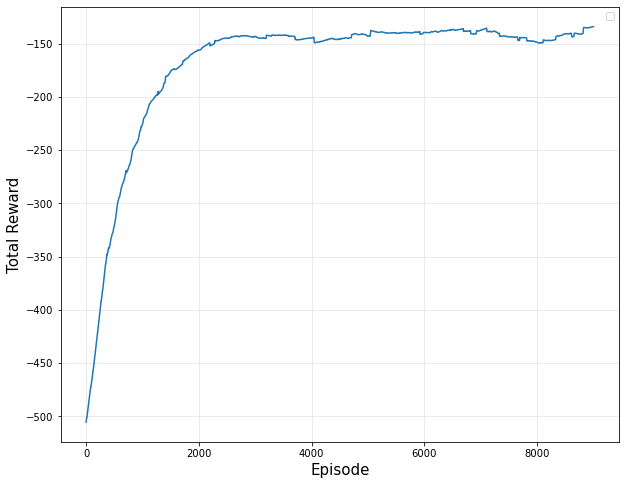

In [116]:
plot_progress_curve([mean_rewards_on_policy_4_step_sarsa], 1000)

### Comparisons

### 2 step Sarsa Vs tree backup

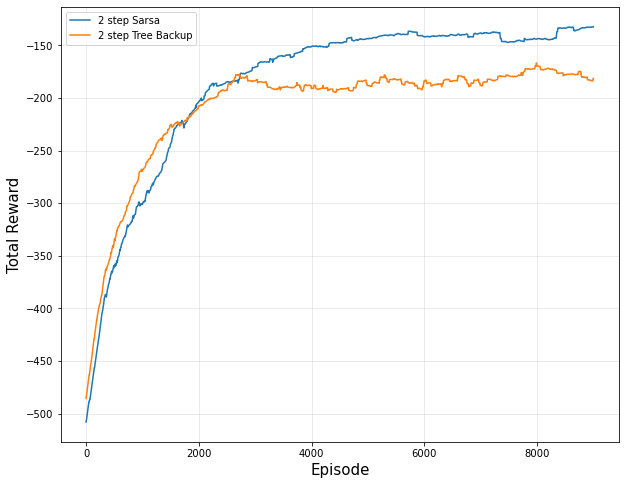

In [117]:
reward_lists = [mean_rewards_on_policy_2_step_sarsa, mean_rewards_2_step_tree_backup]
plot_progress_curve(reward_lists, 1000, ['2 step Sarsa', '2 step Tree Backup'])

**From the above graph it can be clearly seen that following points can be discerned:**

* **Speed of convergence** : At the start the speed of convergence seem to be faster for the tree backup but it stops improving after some episodes.


* **max reward achieved** : Max average reward is achieved by 2 step sarsa and it seems that tree backup improves little as compared to the 2 step sarsa after 2500 episodes before which both had similar average rewards.

### 3 step Sarsa Vs tree backup

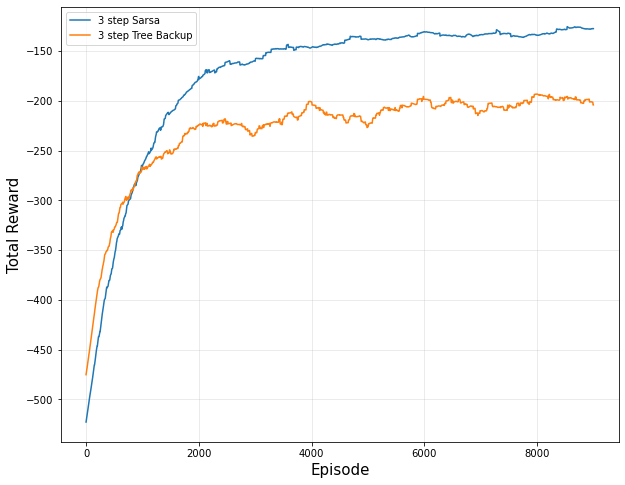

In [118]:
reward_lists = [mean_rewards_on_policy_3_step_sarsa, mean_rewards_3_step_tree_backup]
plot_progress_curve(reward_lists, 1000, ['3 step Sarsa', '3 step Tree Backup'])

**From the above graph it can be clearly seen that following points can be discerned:**

* **Speed of convergence** : At the start the speed of convergence seem to be faster for the tree backup but it stops improving after some episodes.


* **max reward achieved** : Max average reward is achieved by 3 step sarsa and it seems that tree backup improves little as compared to the 3 step sarsa after 1000 episodes before which both had similar average rewards.

### 4 step Sarsa Vs tree backup

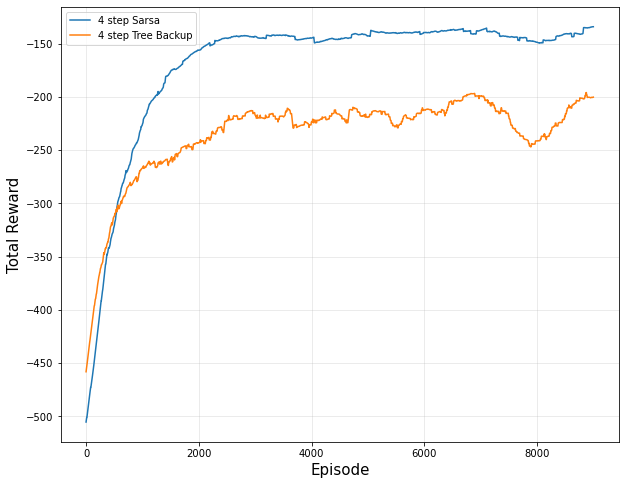

In [119]:
reward_lists = [mean_rewards_on_policy_4_step_sarsa, mean_rewards_4_step_tree_backup]
plot_progress_curve(reward_lists, 1000, ['4 step Sarsa', '4 step Tree Backup'])

**From the above graph it can be clearly seen that following points can be discerned:**

* **Speed of convergence** : At the start the speed of convergence seem to be faster for the tree backup but it stops improving after some episodes.

* **max reward achieved** : Max average reward is achieved by 4 step sarsa and it seems that tree backup improves little as compared to the 4 step sarsa after 500 episodes before which both had similar average rewards.